# 1. Install and Import libraries

In [1]:
!pip install arch

  Obtaining dependency information for arch from https://files.pythonhosted.org/packages/3b/ad/c2469616c462d50f14ca33adb8819157a04ba2c3b3a56e79b6a4d734bb36/arch-7.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 26.3 MB/s eta 0:00:0000:01


In [2]:
!pip install numba

In [3]:
#NLP Transformers library
from transformers import AutoTokenizer, Trainer,  DataCollatorWithPadding, AutoModel,AutoModelForSequenceClassification, TrainingArguments
from datasets import Dataset, DatasetDict
import pandas as pd
import numpy as np
#ARCH modeling
import arch
import torch
import wandb
#plots
import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error,  f1_score,\
accuracy_score, precision_score, recall_score, mean_absolute_error, roc_auc_score,RocCurveDisplay,\
precision_recall_curve, auc
#misc
from collections import Counter
import gc
import random
import re

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
#fixing random seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [5]:
def compute_metrics(pred):
    '''
    Evaluates classification metrics
    '''
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1 
    }

def cleanup():
    '''
    cleans VRAM cache memory
    '''
    torch.cuda.empty_cache()
    gc.collect()

# 2. Data loading and preprocessing

In [6]:
# read daily MOEX index data from 2013 to 2020
moex_data_13 = pd.read_csv('/kaggle/input/moex-news-russian/IMOEX_130101_141231.csv',sep = ";")
moex_data = pd.read_csv('/kaggle/input/moex-news-russian/IMOEX_150101_200101.csv',sep = ";")
# data from COVID period
covid_moex_data = pd.read_csv('/kaggle/input/moex-news-russian/IMOEX_200101_220101.csv',sep = ";")
full_data = pd.concat([moex_data,covid_moex_data])

In [7]:
moex_data_13['date'] = pd.to_datetime(moex_data_13['<DATE>'].astype(str),yearfirst=True,format="%y%m%d")

In [8]:
moex_data['date'] = pd.to_datetime(moex_data['<DATE>'].astype(str))

In [9]:
moex_data = pd.concat([moex_data_13, moex_data])

In [10]:
moex_data = moex_data.reset_index(drop=True)
full_data = full_data.reset_index(drop=True)

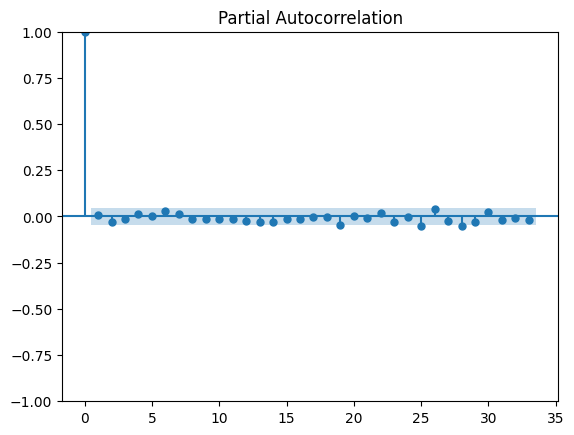

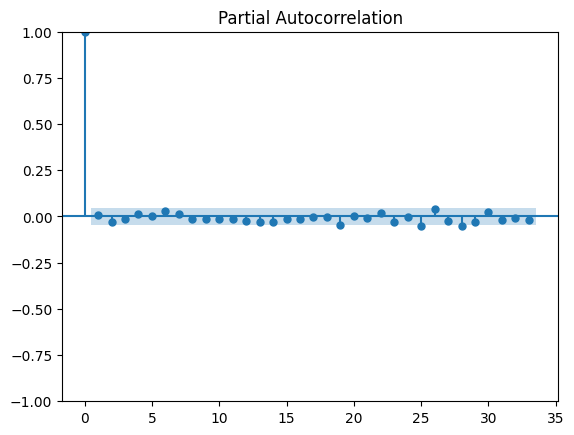

In [11]:
# calculate log-returns
moex_data['return'] = 100 * moex_data['<CLOSE>'].pct_change()
moex_data['log_ret'] = np.log(moex_data['<CLOSE>']/moex_data['<CLOSE>'].shift(1))
moex_data = moex_data.dropna()
#plot autocorrelation
plot_pacf(moex_data['log_ret'])

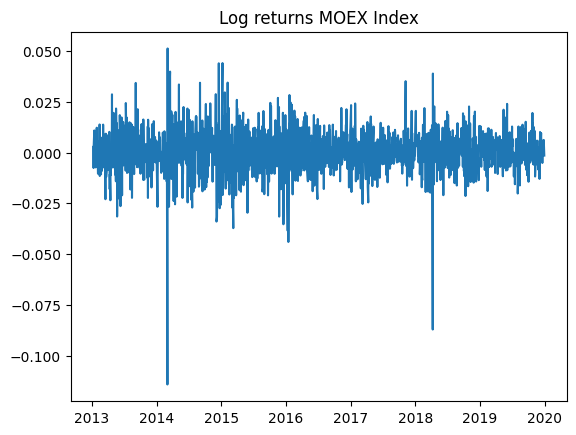

In [12]:
plt.plot(moex_data['date'],moex_data['log_ret'])
plt.title("Log returns MOEX Index")
plt.show()

In [13]:
moex_data[['<DATE>','<CLOSE>','return','log_ret']].to_csv('returns.csv')

In [14]:
# read news data
data = pd.read_csv('/kaggle/input/moex-news-russian/moex_data_1.csv',encoding='utf16',sep=',',header=0,quotechar='"',engine="python")
data['index'] = data['Unnamed: 0'].str.split(',')
data['class'] = data['index'].apply(lambda x :x[-1])
data['docid'] = data['index'].apply(lambda x: x[1])
data['index'] = data['index'].apply(lambda x :x[0]).astype(int)

In [15]:
og = pd.read_csv('/kaggle/input/moex-news-russian/news_lenta/moex_data.csv',encoding='utf32')
og['index'] = og['Unnamed: 0']
og = og.drop(columns='class')

fin = og.merge(data[['index','class']],how='inner',on='index')
fin = fin[['index','text','title','pubdate','class']]
fin['date']=pd.to_datetime(fin['pubdate'],unit='s')
fin = fin.reset_index()
fin['date']= fin['date'].dt.date
fin['date'] = pd.to_datetime(fin['date']).dt.normalize()
#fin = fin.set_index('date')
fin['class'] = fin['class'].astype(int)
fin = fin.rename(columns={"class":"labels"})
s = fin[['date','title','text','labels']].copy()
s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977 entries, 0 to 1976
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1977 non-null   datetime64[ns]
 1   title   1977 non-null   object        
 2   text    1977 non-null   object        
 3   labels  1977 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 61.9+ KB


In [16]:
data_upd = pd.read_csv('/kaggle/input/moex-news-russian/moex_data_13-21.csv',encoding='utf16',sep=',',header=0,quotechar='"',engine="python")
data_upd = data_upd.iloc[0:922]
data_upd['index'] = data_upd['Unnamed: 0'].str.split(',')
data_upd['class'] = data_upd['index'].apply(lambda x:x[-1])
data_upd['index'] = data_upd['index'].apply(lambda x:x[0]).astype(int)
data_upd.head()

,Unnamed: 0,docid,lastmodtime,part,title,type,url,modified,text,pubdate,date,flag,class,index
0,"0,487658,1670854754,0,Россия сократила добычу ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,"1,487831,1670854796,0,Первые торги 2013 года н...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
2,"2,487943,1670854825,0,Александр Лебедев решил ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
3,"3,487942,1670854825,0,""""""Роснефть"""" увеличит п...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3
4,"4,488063,1670854853,0,Упавший на ЛЭП кран обес...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4


In [17]:
og = pd.read_csv('/kaggle/input/moex-news-russian/moex_data.csv',encoding='utf32')
og['index'] = og['Unnamed: 0']
og = og.drop(columns='class')
fin = og.merge(data_upd[['index','class']],how='inner',on="index")

In [18]:
fin = fin[['index','text','title','pubdate','class']]
fin['date']=pd.to_datetime(fin['pubdate'],unit='s')
fin = fin.reset_index()
fin['date']= fin['date'].dt.date
fin['date'] = pd.to_datetime(fin['date']).dt.normalize()
#fin = fin.set_index('date')
fin['class'] = fin['class'].astype(int)
fin = fin.rename(columns={"class":"labels"})
n = fin[['date','title','text','labels']].copy()
n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    922 non-null    datetime64[ns]
 1   title   922 non-null    object        
 2   text    922 non-null    object        
 3   labels  922 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 28.9+ KB


In [19]:
s = pd.concat([n,s])

In [20]:
train = s[s.date<pd.to_datetime("2018-01-01")].copy() 
test = s[s.date>=pd.to_datetime("2018-01-01")].copy()
val = test[test.date>=pd.to_datetime("2019-07-01")].copy()
test = test[test.date<pd.to_datetime("2019-07-01")].copy()
news_train = Dataset.from_pandas(train[['date','title','text','labels']])
news_test = Dataset.from_pandas(test[['date','title','text','labels']])
news_val = Dataset.from_pandas(val[['date','title','text','labels']])

news_dataset = DatasetDict()
news_dataset['train'] = news_train 
news_dataset['test'] = news_test
news_dataset['val'] = news_val

In [21]:
len(s)

2899

In [22]:
print(Counter(train['labels']))
print(Counter(test['labels']))
print(Counter(val['labels']))

Counter({0: 837, 1: 797})
Counter({1: 429, 0: 394})
Counter({1: 235, 0: 207})


In [23]:
s = s[['date','labels']]
s = s.set_index('date')

mean_ind = s.resample('D').mean()
mean_ind = mean_ind.fillna(0.5)
mean_ind = moex_data.merge(mean_ind,on='date',how='left')
mean_ind = mean_ind[['date','labels']]
mean_ind.to_csv('news_data.csv')

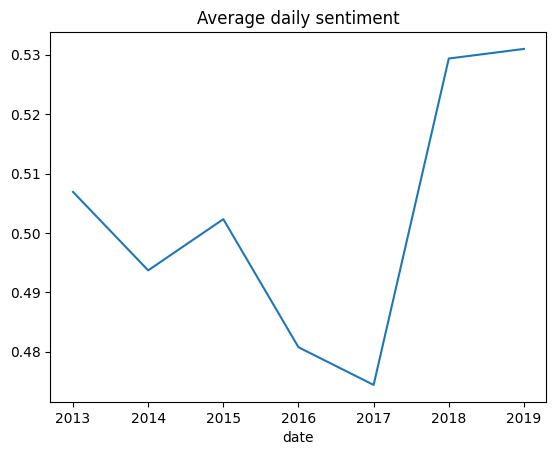

In [24]:
mean_ind.groupby(mean_ind.date.dt.year)['labels'].mean().plot()
plt.title("Mean sentiment distribution")
plt.title("Average daily sentiment")
plt.show()

# 3. Fine-tuning russian LLM on manually labeled dataset

## 3.1 LABSE model 

In [ ]:
#model and tokenizer initialization(LaBSE-en-ru)
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModelForSequenceClassification.from_pretrained("cointegrated/LaBSE-en-ru", num_labels=2)

In [ ]:
#turn off base_model trainig
#for param in model.base_model.parameters():
    #param.requires_grad = False

training_args = TrainingArguments(
    output_dir='./labse_clf',
    learning_rate=1e-5,
    num_train_epochs=7,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy='epoch'
)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

In [89]:
wandb.init(mode='disabled')

In [90]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding='max_length', max_length=256)

tokenized_datasets = news_dataset.map(tokenize_function, batched=True, batch_size=32)

trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['test'],
    tokenizer = tokenizer,
    compute_metrics=compute_metrics,
    )

trainer.train()



  0%|          | 0/52 [00:00<?, ?ba/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.689600,0.663547,0.585662,0.584945,0.585662,0.581831
2,0.621600,0.676880,0.605103,0.626649,0.605103,0.595323
3,0.573500,0.685529,0.612394,0.631992,0.612394,0.604272
4,0.524700,0.686990,0.626974,0.627127,0.626974,0.624215
5,0.488400,0.706285,0.633050,0.636473,0.633050,0.632776
6,0.458200,0.727852,0.624544,0.624405,0.624544,0.622239
7,0.438400,0.739606,0.628190,0.627740,0.628190,0.627664


TrainOutput(global_step=364, training_loss=0.5420591071411803, metrics={'train_runtime': 328.4383, 'train_samples_per_second': 34.825, 'train_steps_per_second': 1.108, 'total_flos': 1504732125603840.0, 'train_loss': 0.5420591071411803, 'epoch': 7.0})

In [91]:
predictions = trainer.predict(tokenized_datasets['test'])
preds = torch.softmax(torch.tensor(predictions.predictions),dim=1)

In [46]:
labels = torch.argmax(preds, 1)
test['prob_0'] = preds[:,1]
test['prob_1'] = preds[:,0]
test.to_csv("preds.csv",encoding='utf-32')

In [ ]:
accuracy = accuracy_score(tokenized_datasets['test']['labels'],np.array(labels))
precision = precision_score(tokenized_datasets['test']['labels'], np.array(labels))
recall = recall_score(tokenized_datasets['test']['labels'],np.array(labels))
f1 = f1_score(tokenized_datasets['test']['labels'],np.array(labels))
roc_auc = roc_auc_score(tokenized_datasets['test']['labels'],test['prob_0'])

In [ ]:
print("Test metrics")
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F1:",f1)
print("ROC_AUC:",roc_auc)

In [ ]:
predictions_train = trainer.predict(tokenized_datasets['train'])
preds_train = torch.softmax(torch.tensor(predictions_train.predictions),dim=1)
labels_train = torch.argmax(preds_train, 1)

In [ ]:
accuracy_train = accuracy_score(tokenized_datasets['train']['labels'],np.array(labels_train))
precision_train = precision_score(tokenized_datasets['train']['labels'], np.array(labels_train))
recall_train = recall_score(tokenized_datasets['train']['labels'],np.array(labels_train))
f1_train = f1_score(tokenized_datasets['train']['labels'],np.array(labels_train))
roc_auc_train = roc_auc_score(tokenized_datasets['train']['labels'],preds_train[:,1])

In [ ]:
print("Train Metrics")
print("Accuracy:",accuracy_train)
print("Precision:",precision_train)
print("Recall:",recall_train)
print("F1:",f1_train)
print("ROC_AUC:",roc_auc_train)

In [ ]:
cleanup()

## 3.2 SBERT LARGE NLU

In [26]:
def model_init(trial):
    model = AutoModelForSequenceClassification.from_pretrained(
        "ai-forever/sbert_large_mt_nlu_ru",
        num_labels=2
    )
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    for param in model.base_model.parameters():
        param.requires_grad = False
    return model

In [27]:
#model and tokenizer initialization(ruBert-base)
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_mt_nlu_ru")
#model = AutoModelForSequenceClassification.from_pretrained("ai-forever/sbert_large_mt_nlu_ru", num_labels=2)

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [28]:
#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#model.to(device)

In [29]:
#turn off base_model trainig
#for param in model.base_model.parameters():
    #param.requires_grad = False

training_args = TrainingArguments(
    output_dir='./sbert_clf',
    learning_rate=5e-6,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy='epoch'
)

In [30]:
wandb.init(mode='disabled')

In [32]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding='max_length', max_length=256)

tokenized_datasets = news_dataset.map(tokenize_function, batched=True, batch_size=16)

trainer = Trainer(
    model=None,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['test'],
    tokenizer = tokenizer,
    model_init=model_init,
    compute_metrics=compute_metrics
    )





  0%|          | 0/103 [00:00<?, ?ba/s]

  0%|          | 0/52 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True),
        "epoch": trial.suggest_categorical('epoch',[1,2,3,4,5])
    }

In [34]:
best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=30
)

[I 2024-09-03 13:06:04,846] A new study created in memory with name: no-name-55ddf297-49af-4144-8dca-e3abeba55871
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.740600,0.720473,0.521264,0.271716,0.521264,0.357224
2,0.733300,0.717663,0.521264,0.271716,0.521264,0.357224


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-09-03 13:09:25,111] Trial 0 finished with value: 1.671466976772799 and parameters: {'learning_rate': 3.5397101899883347e-06, 'epoch': 1}. Best is trial 0 with value: 1.671466976772799.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-f

eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


wandb: Currently logged in as: avsayapin. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.741100,0.721278,0.521264,0.271716,0.521264,0.357224
2,0.734500,0.718641,0.521264,0.271716,0.521264,0.357224


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-09-03 13:12:24,411] Trial 1 finished with value: 1.671466976772799 and parameters: {'learning_rate': 3.2440335233606484e-06, 'epoch': 4}. Best is trial 0 with value: 1.671466976772799.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-f

eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.727300,0.703362,0.521264,0.271716,0.521264,0.357224
2,0.709800,0.698947,0.521264,0.271716,0.521264,0.357224


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-09-03 13:15:24,541] Trial 2 finished with value: 1.671466976772799 and parameters: {'learning_rate': 1.1930138854332864e-05, 'epoch': 5}. Best is trial 0 with value: 1.671466976772799.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-f

eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.742500,0.723313,0.521264,0.271716,0.521264,0.357224
2,0.737300,0.721142,0.521264,0.271716,0.521264,0.357224


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-09-03 13:18:22,161] Trial 3 finished with value: 1.671466976772799 and parameters: {'learning_rate': 2.521256913141552e-06, 'epoch': 5}. Best is trial 0 with value: 1.671466976772799.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-fo

eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.688000,0.675170,0.592953,0.626305,0.592953,0.574826
2,0.664400,0.672875,0.589307,0.626137,0.589307,0.568460


[I 2024-09-03 13:21:19,337] Trial 4 finished with value: 2.3732115759411183 and parameters: {'learning_rate': 0.00034036510625884306, 'epoch': 2}. Best is trial 4 with value: 2.3732115759411183.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,█▁
eval/f1,█▁
eval/loss,█▁
eval/precision,█▁
eval/recall,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.691200,0.683722,0.569866,0.643701,0.569866,0.522869
2,0.673400,0.676839,0.589307,0.619294,0.589307,0.572551


[I 2024-09-03 13:24:16,304] Trial 5 finished with value: 2.370459747166181 and parameters: {'learning_rate': 0.00020576535340702053, 'epoch': 5}. Best is trial 4 with value: 2.3732115759411183.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,█▁
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.707500,0.689658,0.518834,0.510787,0.518834,0.477952
2,0.689500,0.688653,0.533414,0.530508,0.533414,0.525788


[I 2024-09-03 13:27:13,961] Trial 6 finished with value: 2.123124475725183 and parameters: {'learning_rate': 3.631704053852008e-05, 'epoch': 4}. Best is trial 4 with value: 2.3732115759411183.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.696800,0.689804,0.528554,0.588929,0.528554,0.463815
2,0.683400,0.685340,0.572296,0.595850,0.572296,0.556993


[I 2024-09-03 13:30:11,752] Trial 7 finished with value: 2.2974361664316354 and parameters: {'learning_rate': 8.567836986634967e-05, 'epoch': 4}. Best is trial 4 with value: 2.3732115759411183.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.690700,0.682413,0.574727,0.637938,0.574727,0.535029
2,0.671800,0.675869,0.588092,0.618873,0.588092,0.570637


[I 2024-09-03 13:33:09,584] Trial 8 finished with value: 2.365694030383882 and parameters: {'learning_rate': 0.00022716599992897167, 'epoch': 1}. Best is trial 4 with value: 2.3732115759411183.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,█▁
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.724300,0.700120,0.521264,0.271716,0.521264,0.357224


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-09-03 13:34:57,018] Trial 9 pruned. 
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.679900,0.663416,0.601458,0.623392,0.601458,0.591106
2,0.645800,0.671311,0.592953,0.630335,0.592953,0.572529


[I 2024-09-03 13:37:55,422] Trial 10 finished with value: 2.388768723768885 and parameters: {'learning_rate': 0.0009673672626496442, 'epoch': 2}. Best is trial 10 with value: 2.388768723768885.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,█▁
eval/f1,█▁
eval/loss,▁█
eval/precision,▁█
eval/recall,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.679900,0.663145,0.601458,0.621729,0.601458,0.592058
2,0.646500,0.671214,0.592953,0.630335,0.592953,0.572529


[I 2024-09-03 13:40:52,390] Trial 11 finished with value: 2.388768723768885 and parameters: {'learning_rate': 0.0009227977070592334, 'epoch': 2}. Best is trial 10 with value: 2.388768723768885.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,█▁
eval/f1,█▁
eval/loss,▁█
eval/precision,▁█
eval/recall,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.679900,0.663368,0.601458,0.622827,0.601458,0.591429
2,0.645900,0.671293,0.592953,0.630335,0.592953,0.572529


[I 2024-09-03 13:43:50,100] Trial 12 finished with value: 2.388768723768885 and parameters: {'learning_rate': 0.0009603958152180243, 'epoch': 2}. Best is trial 10 with value: 2.388768723768885.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,█▁
eval/f1,█▁
eval/loss,▁█
eval/precision,▁█
eval/recall,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.680000,0.663015,0.605103,0.625532,0.605103,0.595941
2,0.647000,0.671170,0.590522,0.628098,0.590522,0.569496


[I 2024-09-03 13:46:54,386] Trial 13 finished with value: 2.3786389663971637 and parameters: {'learning_rate': 0.000891918630465548, 'epoch': 3}. Best is trial 10 with value: 2.388768723768885.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,█▁
eval/f1,█▁
eval/loss,▁█
eval/precision,▁█
eval/recall,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.684800,0.669534,0.597813,0.611789,0.597813,0.591815
2,0.658400,0.671808,0.591738,0.634609,0.591738,0.568023


[I 2024-09-03 13:49:52,778] Trial 14 finished with value: 2.386107205312436 and parameters: {'learning_rate': 0.00046126771764817213, 'epoch': 2}. Best is trial 10 with value: 2.388768723768885.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,█▁
eval/f1,█▁
eval/loss,▁█
eval/precision,▁█
eval/recall,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.696000,0.689578,0.522479,0.579854,0.522479,0.454296


[I 2024-09-03 13:51:40,965] Trial 15 pruned. 
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.694600,0.688724,0.533414,0.607163,0.533414,0.464174


[I 2024-09-03 13:53:27,989] Trial 16 pruned. 
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.745300,0.727646,0.521264,0.271716,0.521264,0.357224


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-09-03 13:55:15,481] Trial 17 pruned. 
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.682500,0.665908,0.600243,0.613167,0.600243,0.594994
2,0.654000,0.671509,0.594168,0.636838,0.594168,0.571106


[I 2024-09-03 13:58:13,215] Trial 18 finished with value: 2.396278726391339 and parameters: {'learning_rate': 0.0005810920518997453, 'epoch': 2}. Best is trial 18 with value: 2.396278726391339.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,█▁
eval/f1,█▁
eval/loss,▁█
eval/precision,▁█
eval/recall,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.685800,0.671233,0.594168,0.611133,0.594168,0.586102
2,0.660300,0.672043,0.592953,0.633856,0.592953,0.570579


[I 2024-09-03 14:01:10,173] Trial 19 finished with value: 2.390340368900702 and parameters: {'learning_rate': 0.0004184360299224615, 'epoch': 2}. Best is trial 18 with value: 2.396278726391339.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,█▁
eval/f1,█▁
eval/loss,▁█
eval/precision,▁█
eval/recall,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.705000,0.689427,0.537060,0.534615,0.537060,0.531577


[I 2024-09-03 14:02:57,538] Trial 20 pruned. 
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.685000,0.669861,0.595383,0.610439,0.595383,0.588581
2,0.658800,0.671847,0.591738,0.634609,0.591738,0.568023


[I 2024-09-03 14:05:54,729] Trial 21 finished with value: 2.386107205312436 and parameters: {'learning_rate': 0.0004524614185625399, 'epoch': 2}. Best is trial 18 with value: 2.396278726391339.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,█▁
eval/f1,█▁
eval/loss,▁█
eval/precision,▁█
eval/recall,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.685600,0.670756,0.596598,0.613337,0.596598,0.588865
2,0.659800,0.671969,0.592953,0.635726,0.592953,0.569566


[I 2024-09-03 14:08:52,077] Trial 22 finished with value: 2.3911969387782546 and parameters: {'learning_rate': 0.00042976058125533445, 'epoch': 2}. Best is trial 18 with value: 2.396278726391339.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,█▁
eval/f1,█▁
eval/loss,▁█
eval/precision,▁█
eval/recall,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.691600,0.684678,0.558931,0.633734,0.558931,0.506097


[I 2024-09-03 14:10:39,601] Trial 23 pruned. 
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.684000,0.668244,0.597813,0.610971,0.597813,0.592298
2,0.656900,0.671680,0.591738,0.634609,0.591738,0.568023


[I 2024-09-03 14:13:36,569] Trial 24 finished with value: 2.386107205312436 and parameters: {'learning_rate': 0.0004985753755966401, 'epoch': 2}. Best is trial 18 with value: 2.396278726391339.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,█▁
eval/f1,█▁
eval/loss,▁█
eval/precision,▁█
eval/recall,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.693200,0.687256,0.543135,0.622200,0.543135,0.478406


[I 2024-09-03 14:15:24,526] Trial 25 pruned. 
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.688700,0.676832,0.579587,0.616970,0.579587,0.556219


[I 2024-09-03 14:17:12,264] Trial 26 pruned. 
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.697700,0.689934,0.521264,0.566585,0.521264,0.462491


[I 2024-09-03 14:18:59,429] Trial 27 pruned. 
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.682900,0.666529,0.599028,0.611672,0.599028,0.593878
2,0.654800,0.671551,0.594168,0.636838,0.594168,0.571106


[I 2024-09-03 14:21:58,450] Trial 28 finished with value: 2.396278726391339 and parameters: {'learning_rate': 0.0005566196893734825, 'epoch': 2}. Best is trial 18 with value: 2.396278726391339.
Trying to set epoch in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,█▁
eval/f1,█▁
eval/loss,▁█
eval/precision,▁█
eval/recall,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.690000,0.680331,0.585662,0.639562,0.585662,0.554499


[I 2024-09-03 14:23:46,396] Trial 29 pruned. 


In [37]:
best_trial

BestRun(run_id='18', objective=2.396278726391339, hyperparameters={'learning_rate': 0.0005810920518997453, 'epoch': 2}, run_summary=None)

In [25]:
#model and tokenizer initialization
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_mt_nlu_ru")
model = AutoModelForSequenceClassification.from_pretrained("ai-forever/sbert_large_mt_nlu_ru", num_labels=2)

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/866 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024

In [27]:
freeze=0
if freeze==1:
    for param in model.base_model.parameters():
        param.requires_grad = False
else:
    pass

training_args = TrainingArguments(
    output_dir='./sbert_clf',
    learning_rate=2e-5,
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay = 0.0001,
    evaluation_strategy="epoch",
    logging_strategy='epoch'
)

In [28]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding='max_length', max_length=128)

tokenized_datasets = news_dataset.map(tokenize_function, batched=True, batch_size=16)

trainer = Trainer(
    model=model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['test'],
    tokenizer = tokenizer,
    compute_metrics=compute_metrics
    )

  0%|          | 0/103 [00:00<?, ?ba/s]

  0%|          | 0/52 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

In [29]:
wandb.init(mode='disabled')

In [30]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.637900,0.686203,0.605103,0.605448,0.605103,0.600426
2,0.479600,0.748244,0.626974,0.629825,0.626974,0.626839


TrainOutput(global_step=206, training_loss=0.5587599856182209, metrics={'train_runtime': 170.9511, 'train_samples_per_second': 19.117, 'train_steps_per_second': 1.205, 'total_flos': 761387923838976.0, 'train_loss': 0.5587599856182209, 'epoch': 2.0})

In [31]:
predictions = trainer.predict(tokenized_datasets['test'])
preds = torch.softmax(torch.tensor(predictions.predictions),dim=1)

In [32]:
labels = torch.argmax(preds, 1)
test['prob_0'] = preds[:,0]
test['prob_1'] = preds[:,1]
test.to_csv("preds.csv",encoding='utf-32')

In [33]:
accuracy = accuracy_score(tokenized_datasets['test']['labels'],np.array(labels))
precision = precision_score(tokenized_datasets['test']['labels'], np.array(labels))
recall = recall_score(tokenized_datasets['test']['labels'],np.array(labels))
f1 = f1_score(tokenized_datasets['test']['labels'],np.array(labels))
roc_auc = roc_auc_score(tokenized_datasets['test']['labels'],test['prob_1'])

In [34]:
print('test')
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F1:",f1)
print("ROC_AUC:",roc_auc)

test
Accuracy: 0.6269744835965978
Precision: 0.6572164948453608
Recall: 0.5944055944055944
F1: 0.624235006119951
ROC_AUC: 0.6735206417947535


In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

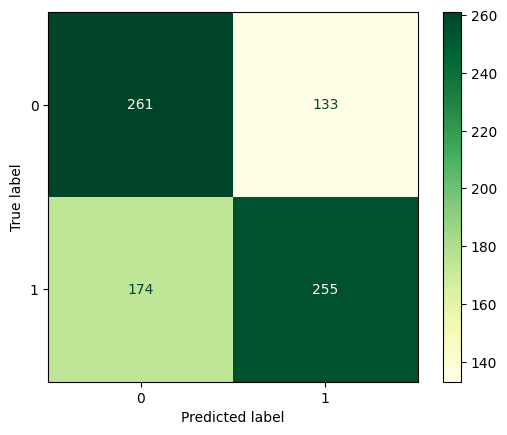

In [36]:
ConfusionMatrixDisplay.from_predictions(tokenized_datasets['test']['labels'],np.array(labels),cmap='YlGn')

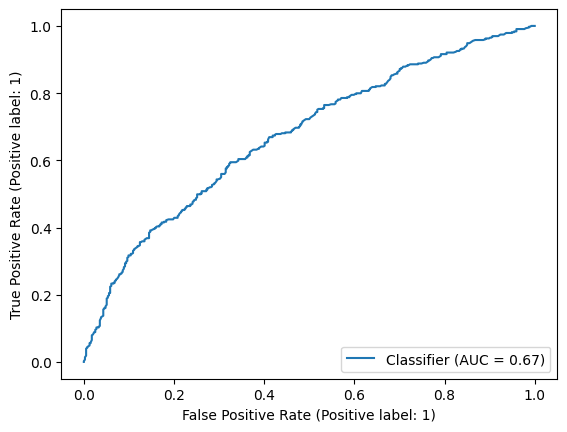

In [37]:
RocCurveDisplay.from_predictions(tokenized_datasets['test']['labels'], test['prob_1'])
plt.show()

In [38]:
predictions = trainer.predict(tokenized_datasets['val'])
preds = torch.softmax(torch.tensor(predictions.predictions),dim=1)
labels = torch.argmax(preds, 1)
val['prob_1'] = preds[:,1]
val['prob_0'] = preds[:,0]
val.to_csv("preds_val.csv",encoding='utf-32')

In [39]:
accuracy = accuracy_score(tokenized_datasets['val']['labels'],np.array(labels))
precision = precision_score(tokenized_datasets['val']['labels'], np.array(labels))
recall = recall_score(tokenized_datasets['val']['labels'],np.array(labels))
f1 = f1_score(tokenized_datasets['val']['labels'],np.array(labels))
roc_auc = roc_auc_score(tokenized_datasets['val']['labels'],val['prob_1'])

In [40]:
print('val')
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F1:",f1)
print("ROC_AUC:",roc_auc)

val
Accuracy: 0.6493212669683258
Precision: 0.66
Recall: 0.7021276595744681
F1: 0.6804123711340208
ROC_AUC: 0.713413506012951


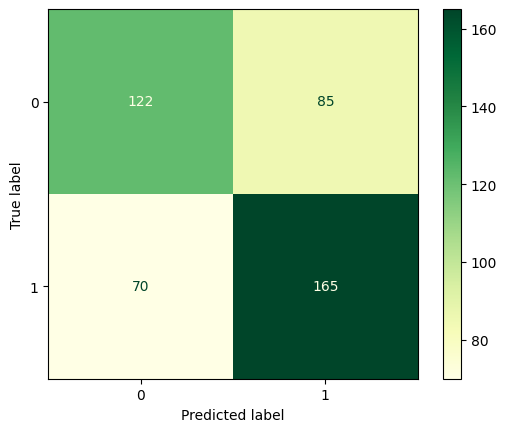

In [41]:
ConfusionMatrixDisplay.from_predictions(tokenized_datasets['val']['labels'],np.array(labels),cmap='YlGn')

In [42]:
predictions = trainer.predict(tokenized_datasets['train'])
preds = torch.softmax(torch.tensor(predictions.predictions),dim=1)

In [43]:
labels = torch.argmax(preds, 1)

In [44]:
accuracy = accuracy_score(tokenized_datasets['train']['labels'],np.array(labels))
precision = precision_score(tokenized_datasets['train']['labels'], np.array(labels))
recall = recall_score(tokenized_datasets['train']['labels'],np.array(labels))
f1 = f1_score(tokenized_datasets['train']['labels'],np.array(labels))
roc_auc = roc_auc_score(tokenized_datasets['train']['labels'],preds[:,1])

In [45]:
print('train')
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F1:",f1)
print("ROC_AUC:",roc_auc)

train
Accuracy: 0.8543451652386781
Precision: 0.8515723270440252
Recall: 0.849435382685069
F1: 0.8505025125628141
ROC_AUC: 0.9240101395765782


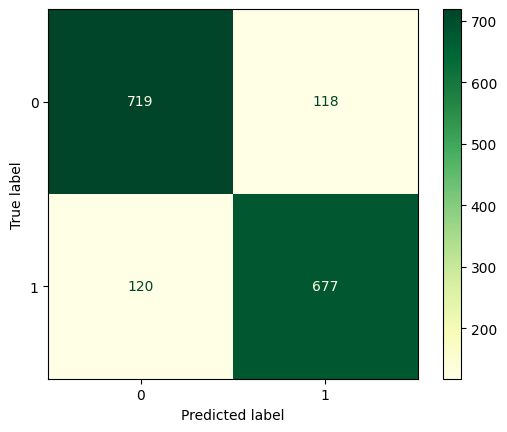

In [46]:
ConfusionMatrixDisplay.from_predictions(tokenized_datasets['train']['labels'],np.array(labels),cmap='YlGn')

In [47]:
cleanup()

## 3.3 tinybert

In [155]:
#model and tokenizer initialization(rubert-tiny2)
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

In [156]:
def model_init(trial):
    model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2", num_labels=2)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    return model

In [157]:
training_args = TrainingArguments(
    output_dir='./tinybert_clf',
    learning_rate=1e-2,
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy='epoch'
)

In [158]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding='max_length', max_length=256)

tokenized_datasets = news_dataset.map(tokenize_function, batched=True, batch_size=32)

trainer = Trainer(
    model=None,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['test'],
    tokenizer = tokenizer,
    model_init=model_init,
    compute_metrics=compute_metrics
    )

  0%|          | 0/52 [00:00<?, ?ba/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [159]:
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-2, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32]),
        "num_train_epochs": trial.suggest_categorical('num_train_epochs',[2,3,4,5])
    }

In [160]:
best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=30
)

[I 2024-09-02 19:05:14,841] A new study created in memory with name: no-name-31c2f270-4fd5-48a6-86c3-055a249fcc67
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.722300,0.692398,0.521264,0.271716,0.521264,0.357224
2,0.711300,0.695507,0.478736,0.229188,0.478736,0.309979
3,0.694800,0.698592,0.478736,0.229188,0.478736,0.309979


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-09-02 19:06:30,912] Trial 0 finished with value: 1.4966399588267216 and parameters: {'learning_

eval/accuracy,█▁▁
eval/f1,█▁▁
eval/loss,▁▅█
eval/precision,█▁▁
eval/recall,█▁▁
eval/runtime,▇▁█
eval/samples_per_second,▃█▁
eval/steps_per_second,▂█▁
train/epoch,▁▁▅▅███
train/global_step,▁▁▅▅███
train/learning_rate,█▄▁


wandb: Currently logged in as: avsayapin. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.703700,0.692076,0.521264,0.271716,0.521264,0.357224
2,0.702200,0.698189,0.478736,0.229188,0.478736,0.309979
3,0.693400,0.702319,0.478736,0.229188,0.478736,0.309979
4,0.693800,0.681362,0.574727,0.573658,0.574727,0.570897
5,0.594100,0.756147,0.577157,0.582996,0.577157,0.575351


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-09-02 19:07:41,560] Trial 1 finished with value: 2.31266025150063 and parameters: {'learning_ra

eval/accuracy,▄▁▁██
eval/f1,▂▁▁██
eval/loss,▂▃▃▁█
eval/precision,▂▁▁██
eval/recall,▄▁▁██
eval/runtime,█▁▂▁▁
eval/samples_per_second,▁█▇██
eval/steps_per_second,▁█▇██
train/epoch,▁▁▃▃▅▅▆▆███
train/global_step,▁▁▃▃▅▅▆▆███
train/learning_rate,█▆▅▃▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.693500,0.694816,0.483597,0.508942,0.483597,0.367975
2,0.692500,0.694193,0.483597,0.505993,0.483597,0.375680
3,0.690600,0.693757,0.490887,0.529286,0.490887,0.387423
4,0.691100,0.693849,0.483597,0.513114,0.483597,0.359855
5,0.690800,0.693654,0.484812,0.516250,0.484812,0.365464


[I 2024-09-02 19:08:47,929] Trial 2 finished with value: 1.8513380851488102 and parameters: {'learning_rate': 3.6869970233309996e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 5}. Best is trial 1 with value: 2.31266025150063.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▁█▁▂
eval/f1,▃▅█▁▂
eval/loss,█▄▂▂▁
eval/precision,▂▁█▃▄
eval/recall,▁▁█▁▂
eval/runtime,▃▄█▃▁
eval/samples_per_second,▆▅▁▆█
eval/steps_per_second,▆▅▁▆█
train/epoch,▁▁▃▃▅▅▆▆███
train/global_step,▁▁▃▃▅▅▆▆███
train/learning_rate,█▆▅▃▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.705000,0.693609,0.478736,0.229188,0.478736,0.309979
2,0.697200,0.697678,0.478736,0.229188,0.478736,0.309979
3,0.654600,0.758728,0.535844,0.618495,0.535844,0.463748
4,0.484800,0.729080,0.588092,0.590896,0.588092,0.587883
5,0.342200,0.874708,0.585662,0.593438,0.585662,0.582884


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-09-02 19:09:56,467] Trial 3 finished with value: 2.3476465552620627 and parameters: {'learning_rate': 0.0004386018051865029, 'per_device_train_batch_size': 16, 'num_train_epochs': 5}. Best is trial 3 with value: 2.3476465552620627.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.

eval/accuracy,▁▁▅██
eval/f1,▁▁▅██
eval/loss,▁▁▄▂█
eval/precision,▁▁███
eval/recall,▁▁▅██
eval/runtime,▇█▅▁▆
eval/samples_per_second,▂▁▄█▃
eval/steps_per_second,▂▁▄█▃
train/epoch,▁▁▃▃▅▅▆▆███
train/global_step,▁▁▃▃▅▅▆▆███
train/learning_rate,█▆▅▃▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.693400,0.694700,0.483597,0.508275,0.483597,0.369548
2,0.692300,0.693999,0.488457,0.522102,0.488457,0.383035
3,0.690300,0.693509,0.495747,0.543985,0.495747,0.394699
4,0.690600,0.693602,0.482382,0.509276,0.482382,0.354116
5,0.690300,0.693363,0.490887,0.538739,0.490887,0.376897


[I 2024-09-02 19:11:00,196] Trial 4 finished with value: 1.8974105643949828 and parameters: {'learning_rate': 4.245157630718205e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 5}. Best is trial 3 with value: 2.3476465552620627.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▂▄█▁▅
eval/f1,▄▆█▁▅
eval/loss,█▄▂▂▁
eval/precision,▁▄█▁▇
eval/recall,▂▄█▁▅
eval/runtime,█▇▄▁▃
eval/samples_per_second,▁▂▅█▆
eval/steps_per_second,▁▂▅█▆
train/epoch,▁▁▃▃▅▅▆▆███
train/global_step,▁▁▃▃▅▅▆▆███
train/learning_rate,█▆▅▃▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.704200,0.693334,0.478736,0.229188,0.478736,0.309979


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-09-02 19:11:43,867] Trial 5 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.892500,0.697032,0.478736,0.229188,0.478736,0.309979


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-09-02 19:12:38,425] Trial 6 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.703100,0.690504,0.521264,0.271716,0.521264,0.357224
2,0.624800,0.693820,0.569866,0.584396,0.569866,0.561318


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-09-02 19:13:39,434] Trial 7 finished with value: 2.285447125336119 and parameters: {'learning_rate': 0.0007025242824736547, 'per_device_train_batch_size': 16, 'num_train_epochs': 2}. Best is trial 3 with value: 2.3476465552620627.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,▁█
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.691000,0.671232,0.580802,0.590442,0.580802,0.576650
2,0.604400,0.730008,0.579587,0.586224,0.579587,0.577346
3,0.460500,0.827977,0.578372,0.593960,0.578372,0.569842


[I 2024-09-02 19:14:40,534] Trial 8 finished with value: 2.3205462822579674 and parameters: {'learning_rate': 0.00017799196504764047, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}. Best is trial 3 with value: 2.3476465552620627.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,█▄▁
eval/f1,▇█▁
eval/loss,▁▄█
eval/precision,▅▁█
eval/recall,█▄▁
eval/runtime,▁█▆
eval/samples_per_second,█▁▃
eval/steps_per_second,█▁▃
train/epoch,▁▁▅▅███
train/global_step,▁▁▅▅███
train/learning_rate,█▅▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.705000,0.693537,0.478736,0.229188,0.478736,0.309979


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-09-02 19:15:23,388] Trial 9 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.692600,0.688605,0.539490,0.595785,0.539490,0.486123
2,0.672800,0.680687,0.565006,0.586233,0.565006,0.550272


[I 2024-09-02 19:16:23,144] Trial 10 finished with value: 2.266516707222902 and parameters: {'learning_rate': 5.744835720835276e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2}. Best is trial 3 with value: 2.3476465552620627.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,█▁
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.687600,0.674890,0.571081,0.585542,0.571081,0.562709
2,0.633600,0.679307,0.579587,0.590610,0.579587,0.574423
3,0.560900,0.713050,0.568651,0.596374,0.568651,0.549443


[I 2024-09-02 19:17:25,305] Trial 11 finished with value: 2.2831195682243943 and parameters: {'learning_rate': 7.026011964764179e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}. Best is trial 3 with value: 2.3476465552620627.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▃█▁
eval/f1,▅█▁
eval/loss,▁▂█
eval/precision,▁▄█
eval/recall,▃█▁
eval/runtime,▁▄█
eval/samples_per_second,█▅▁
eval/steps_per_second,█▅▁
train/epoch,▁▁▅▅███
train/global_step,▁▁▅▅███
train/learning_rate,█▄▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.692500,0.688708,0.545565,0.602056,0.545565,0.495913
2,0.674700,0.683589,0.568651,0.634623,0.568651,0.525039
3,0.658800,0.673198,0.582017,0.601405,0.582017,0.571160


[I 2024-09-02 19:18:20,486] Trial 12 finished with value: 2.3365987029610613 and parameters: {'learning_rate': 2.522055019531871e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}. Best is trial 3 with value: 2.3476465552620627.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅█
eval/f1,▁▄█
eval/loss,█▆▁
eval/precision,▁█▁
eval/recall,▁▅█
eval/runtime,▁▁█
eval/samples_per_second,██▁
eval/steps_per_second,██▁
train/epoch,▁▁▅▅███
train/global_step,▁▁▅▅███
train/learning_rate,█▅▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.692800,0.690069,0.535844,0.614392,0.535844,0.465904
2,0.678200,0.685791,0.558931,0.632035,0.558931,0.506962


[I 2024-09-02 19:19:09,305] Trial 13 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁██
train/global_step,▁▁██
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.693000,0.690201,0.530984,0.601876,0.530984,0.461384
2,0.677500,0.684419,0.563791,0.632513,0.563791,0.516534


[I 2024-09-02 19:20:03,693] Trial 14 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁██
train/global_step,▁▁██
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.692200,0.687275,0.561361,0.604826,0.561361,0.528370
2,0.671400,0.681085,0.572296,0.631471,0.572296,0.533795
3,0.651200,0.671621,0.584447,0.611461,0.584447,0.568762


[I 2024-09-02 19:21:04,787] Trial 15 finished with value: 2.3491174776964305 and parameters: {'learning_rate': 2.8016043143627374e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}. Best is trial 15 with value: 2.3491174776964305.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▄█
eval/f1,▁▂█
eval/loss,█▅▁
eval/precision,▁█▃
eval/recall,▁▄█
eval/runtime,▁█▁
eval/samples_per_second,█▁█
eval/steps_per_second,█▁█
train/epoch,▁▁▅▅███
train/global_step,▁▁▅▅███
train/learning_rate,█▅▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.690600,0.677831,0.563791,0.596822,0.563791,0.539275
2,0.598300,0.718445,0.551640,0.572084,0.551640,0.534939


[I 2024-09-02 19:21:54,242] Trial 16 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,█▁
eval/f1,█▁
eval/loss,▁█
eval/precision,█▁
eval/recall,█▁
eval/runtime,▁▁
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁██
train/global_step,▁▁██
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.694600,0.695357,0.483597,0.513114,0.483597,0.359855


[I 2024-09-02 19:22:44,490] Trial 17 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.872800,0.700496,0.521264,0.271716,0.521264,0.357224


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-09-02 19:23:42,987] Trial 18 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.694000,0.693635,0.477521,0.477897,0.477521,0.331698


[I 2024-09-02 19:24:37,909] Trial 19 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.692800,0.675516,0.574727,0.573831,0.574727,0.573613
2,0.620600,0.716954,0.584447,0.587314,0.584447,0.584204
3,0.470000,0.837408,0.577157,0.609269,0.577157,0.556673
4,0.355700,0.874112,0.579587,0.581461,0.579587,0.579646
5,0.287200,1.003974,0.575942,0.582592,0.575942,0.573602


[I 2024-09-02 19:25:58,365] Trial 20 finished with value: 2.3080773152393927 and parameters: {'learning_rate': 0.00022997342376234438, 'per_device_train_batch_size': 16, 'num_train_epochs': 5}. Best is trial 15 with value: 2.3491174776964305.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█▃▄▂
eval/f1,▅█▁▇▅
eval/loss,▁▂▄▅█
eval/precision,▁▄█▃▃
eval/recall,▁█▃▄▂
eval/runtime,▂▆█▁▃
eval/samples_per_second,▇▃▁█▆
eval/steps_per_second,▇▃▁█▆
train/epoch,▁▁▃▃▅▅▆▆███
train/global_step,▁▁▃▃▅▅▆▆███
train/learning_rate,█▆▅▃▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.691500,0.684557,0.566221,0.584182,0.566221,0.554416
2,0.665300,0.676498,0.574727,0.616566,0.574727,0.547242
3,0.636900,0.671537,0.580802,0.609324,0.580802,0.563480


[I 2024-09-02 19:26:52,867] Trial 21 finished with value: 2.3344072545347005 and parameters: {'learning_rate': 3.307838107720472e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}. Best is trial 15 with value: 2.3491174776964305.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅█
eval/f1,▄▁█
eval/loss,█▄▁
eval/precision,▁█▆
eval/recall,▁▅█
eval/runtime,▁█▁
eval/samples_per_second,█▁█
eval/steps_per_second,█▁█
train/epoch,▁▁▅▅███
train/global_step,▁▁▅▅███
train/learning_rate,█▅▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.693700,0.693109,0.484812,0.526084,0.484812,0.353697


[I 2024-09-02 19:27:35,760] Trial 22 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.689500,0.677836,0.585662,0.585386,0.585662,0.585482
2,0.648900,0.671129,0.584447,0.604656,0.584447,0.573311
3,0.597500,0.684510,0.580802,0.609324,0.580802,0.563480


[I 2024-09-02 19:28:43,045] Trial 23 finished with value: 2.3344072545347005 and parameters: {'learning_rate': 4.909018532977924e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}. Best is trial 15 with value: 2.3491174776964305.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,█▆▁
eval/f1,█▄▁
eval/loss,▅▁█
eval/precision,▁▇█
eval/recall,█▆▁
eval/runtime,▁█▂
eval/samples_per_second,█▁▇
eval/steps_per_second,█▁▇
train/epoch,▁▁▅▅███
train/global_step,▁▁▅▅███
train/learning_rate,█▄▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.687900,0.677034,0.569866,0.602177,0.569866,0.547524
2,0.624100,0.690342,0.579587,0.587552,0.579587,0.576501
3,0.529900,0.742291,0.560146,0.583474,0.560146,0.542654


[I 2024-09-02 19:29:37,296] Trial 24 finished with value: 2.2464196516589885 and parameters: {'learning_rate': 9.47478138054713e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}. Best is trial 15 with value: 2.3491174776964305.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▅█▁
eval/f1,▂█▁
eval/loss,▁▂█
eval/precision,█▃▁
eval/recall,▅█▁
eval/runtime,▁█▁
eval/samples_per_second,█▁█
eval/steps_per_second,█▁█
train/epoch,▁▁▅▅███
train/global_step,▁▁▅▅███
train/learning_rate,█▅▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.693600,0.692725,0.490887,0.544385,0.490887,0.372145


[I 2024-09-02 19:30:20,273] Trial 25 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.693400,0.694759,0.483597,0.506513,0.483597,0.374171
2,0.692700,0.694393,0.486027,0.510205,0.486027,0.388703


[I 2024-09-02 19:31:20,473] Trial 26 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁██
train/global_step,▁▁██
train/learning_rate,█▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.698900,0.688411,0.579587,0.587833,0.579587,0.576316
2,0.643700,0.711908,0.566221,0.581325,0.566221,0.556813
3,0.479600,0.838730,0.572296,0.593748,0.572296,0.558601
4,0.364400,0.953866,0.583232,0.597253,0.583232,0.576226


[I 2024-09-02 19:32:32,427] Trial 27 finished with value: 2.3399433038108235 and parameters: {'learning_rate': 0.0002828249526244045, 'per_device_train_batch_size': 16, 'num_train_epochs': 4}. Best is trial 15 with value: 2.3491174776964305.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▆▁▄█
eval/f1,█▁▂█
eval/loss,▁▂▅█
eval/precision,▄▁▆█
eval/recall,▆▁▄█
eval/runtime,▁▃█▄
eval/samples_per_second,█▆▁▅
eval/steps_per_second,█▆▁▅
train/epoch,▁▁▃▃▆▆███
train/global_step,▁▁▃▃▆▆███
train/learning_rate,█▆▃▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.711100,0.692318,0.521264,0.271716,0.521264,0.357224


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-09-02 19:33:14,168] Trial 28 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.701300,0.692913,0.495747,0.589619,0.495747,0.368267


[I 2024-09-02 19:34:09,546] Trial 29 pruned. 


In [161]:
best_trial

BestRun(run_id='15', objective=2.3491174776964305, hyperparameters={'learning_rate': 2.8016043143627374e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}, run_summary=None)

In [43]:
cleanup()

In [222]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [223]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

In [224]:
training_args = TrainingArguments(
    output_dir='./tinybert_clf',
    learning_rate=2e-5,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy='epoch'
)

In [225]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding='max_length', max_length=256)

tokenized_datasets = news_dataset.map(tokenize_function, batched=True, batch_size=16)

trainer = Trainer(
    model=model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['test'],
    tokenizer = tokenizer,
    compute_metrics=compute_metrics
    )

  0%|          | 0/103 [00:00<?, ?ba/s]

  0%|          | 0/52 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

In [226]:
wandb.init(mode='disabled')

In [227]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.692900,0.689381,0.552855,0.623477,0.552855,0.498852
2,0.675400,0.682113,0.569866,0.624071,0.569866,0.533233
3,0.649900,0.675972,0.584447,0.609618,0.584447,0.569978
4,0.626100,0.669149,0.590522,0.597355,0.590522,0.588415
5,0.615300,0.669251,0.600243,0.604561,0.600243,0.599502


Checkpoint destination directory ./tinybert_clf/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=515, training_loss=0.6519397994846974, metrics={'train_runtime': 31.5026, 'train_samples_per_second': 259.343, 'train_steps_per_second': 16.348, 'total_flos': 30123635496960.0, 'train_loss': 0.6519397994846974, 'epoch': 5.0})

# 4.Evaluation

## 4.1 Train metrics

In [36]:
predictions_train = trainer.predict(tokenized_datasets['train'])
preds_train = torch.softmax(torch.tensor(predictions_train.predictions),dim=1)
labels_train = torch.argmax(preds_train, 1)

In [37]:
accuracy_train = accuracy_score(tokenized_datasets['train']['labels'],np.array(labels_train))
precision_train = precision_score(tokenized_datasets['train']['labels'], np.array(labels_train))
recall_train = recall_score(tokenized_datasets['train']['labels'],np.array(labels_train))
f1_train = f1_score(tokenized_datasets['train']['labels'],np.array(labels_train))
roc_auc_train = roc_auc_score(tokenized_datasets['train']['labels'],preds_train[:,1])
precision_train_auc, recall_train_auc, thresholds_train = precision_recall_curve(tokenized_datasets['train']['labels'], preds_train[:,1])
auc_precision_recall_train = auc(recall_train_auc, precision_train_auc)

In [38]:
print("Train Metrics")
print(f"Accuracy: {accuracy_train:.2f}")
print(f"Precision: {precision_train:.2f}")
print(f"Recall: {recall_train:.2f}")
print(f"F1: {f1_train:.2f}",)
print(f"ROC_AUC: {roc_auc_train:.2f}")
print(f"PR_AUC: {auc_precision_recall_train:.2f}")

Train Metrics
Accuracy: 0.78
Precision: 0.78
Recall: 0.76
F1: 0.77
ROC_AUC: 0.85
PR_AUC: 0.84


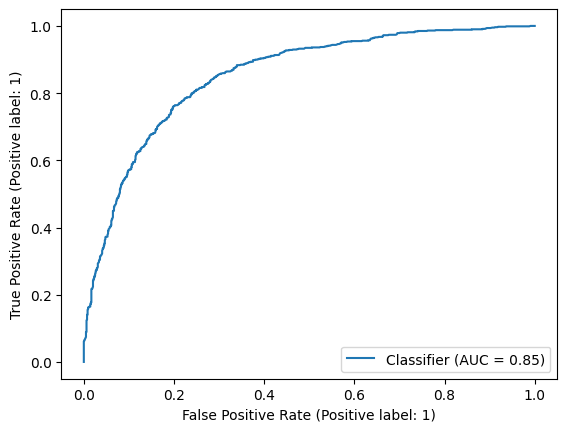

In [39]:
RocCurveDisplay.from_predictions(tokenized_datasets['train']['labels'], preds_train[:,1])
plt.show()

## 4.2 Test metrics

In [99]:
predictions = trainer.predict(tokenized_datasets['test'])
preds = torch.softmax(torch.tensor(predictions.predictions),dim=1)

In [100]:
labels = torch.argmax(preds, 1)
test['prob_1'] = preds[:,1]
test['prob_0'] = preds[:,0]
test.to_csv("preds.csv",encoding='utf-32')

In [101]:
accuracy_test = accuracy_score(tokenized_datasets['test']['labels'],np.array(labels))
precision_test = precision_score(tokenized_datasets['test']['labels'], np.array(labels))
recall_test = recall_score(tokenized_datasets['test']['labels'],np.array(labels))
f1_test = f1_score(tokenized_datasets['test']['labels'],np.array(labels))
roc_auc_test = roc_auc_score(tokenized_datasets['test']['labels'],test['prob_1'])
precision_test_auc, recall_test_auc, thresholds_test = precision_recall_curve(tokenized_datasets['test']['labels'], test['prob_1'])
auc_precision_recall_test = auc(recall_test_auc, precision_test_auc)

In [102]:
print("Test Metrics")
print(f"Accuracy: {accuracy_test:.2f}")
print(f"Precision: {precision_test:.2f}")
print(f"Recall: {recall_test:.2f}")
print(f"F1: {f1_test:.2f}",)
print(f"ROC_AUC: {roc_auc_test:.2f}")
print(f"PR AUC: {auc_precision_recall_test:.2f}")

Test Metrics
Accuracy: 0.64
Precision: 0.69
Recall: 0.56
F1: 0.62
ROC_AUC: 0.68
PR AUC: 0.69


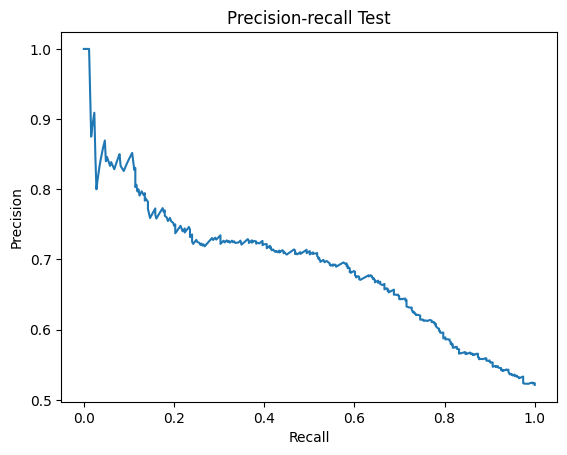

In [103]:
plt.plot(recall_test_auc, precision_test_auc)
plt.title("Precision-recall Test")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

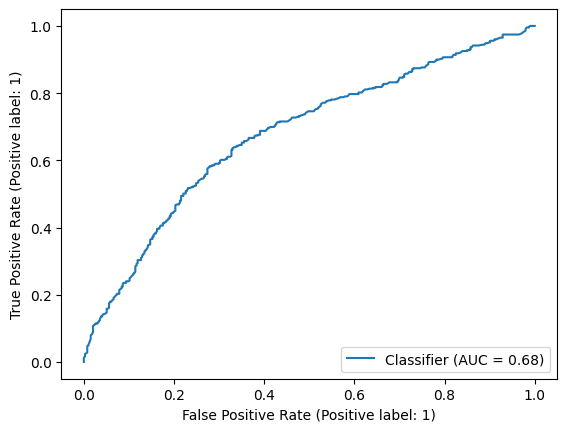

In [104]:
RocCurveDisplay.from_predictions(tokenized_datasets['test']['labels'], test['prob_1'])
plt.show()

In [106]:
predictions = trainer.predict(tokenized_datasets['val'])
preds = torch.softmax(torch.tensor(predictions.predictions),dim=1)
labels = torch.argmax(preds, 1)
val['prob_1'] = preds[:,1]
val['prob_0'] = preds[:,0]
val.to_csv("preds_val.csv",encoding='utf-32')

## 4.3 FiNes

In [48]:
fines = pd.read_csv("/kaggle/input/moex-news-russian/fines.tsv", sep='\t')

In [49]:
fines.head()

,title,score,link,summary,published,tickers
0,Электромобильный стартап Arrival экс-главы Yot...,-0.583333,https://www.rbc.ru/technology_and_media/12/05/...,"Британский электромобильный стартап Arrival, к...","Thu, 12 May 2022 05:10:01 +0300",['ARVL']
1,Экс-глава НМТП рассказал о «напряженных отноше...,-0.314286,https://www.rbc.ru/society/16/11/2020/5fb2709d...,Экс-председатель совета директоров Новороссийс...,"Fri, 20 May 2022 19:13:18 +0300",['NMTP']
2,Шрёдер отклонил предложение войти в совет дире...,-0.333333,https://www.rbc.ru/business/20/05/2022/628772b...,Его кандидатуру выдвинули в начале февраля. Ка...,"Tue, 24 May 2022 22:12:05 +0300",['GAZP']
3,Шельф берут в разработку // Генподрядчиком «Га...,0.700000,https://www.kommersant.ru/doc/5482398,"Как стало известно “Ъ”, «Аврора» Андрея Патруш...","Fri, 29 Jul 2022 00:28:00 +0300",['GAZP']
4,"Чистый убыток ""Юнипро"" в 1 полугодии 2022 года...",-0.611111,https://www.finam.ru/analysis/newsitem/chistyi...,"Чистый убыток ""Юнипро"" в 1 полугодии 2022 года...","Thu, 28 Jul 2022 12:43:00 +0300",['UPRO']


In [50]:
fines['class'] = fines['score']>0

In [51]:
fines['class'] = fines['class']*1

In [52]:
fines_dataset = Dataset.from_pandas(fines[['title','score','class']])

In [53]:
def tokenize_fines(example):
    return tokenizer(example["title"], truncation=True, padding='max_length', max_length=32)

tokenized_fines = fines_dataset.map(tokenize_fines, batched=True, batch_size=16)

  0%|          | 0/34 [00:00<?, ?ba/s]

In [54]:
predictions_fines = trainer.predict(tokenized_fines)
preds_fines = torch.softmax(torch.tensor(predictions_fines.predictions),dim=1)

In [55]:
fines_probs = preds_fines[:,1]*2-1

In [56]:
labels_fines = fines_probs>0
labels_fines = labels_fines*1

In [57]:
accuracy_fines = accuracy_score(tokenized_fines['class'],np.array(labels_fines))
precision_fines = precision_score(tokenized_fines['class'], np.array(labels_fines))
recall_fines = recall_score(tokenized_fines['class'],np.array(labels_fines))
f1_fines = f1_score(tokenized_fines['class'],np.array(labels_fines))
roc_auc = roc_auc_score(tokenized_fines['class'],fines_probs)
precision_fines_auc, recall_fines_auc, thresholds_fines = precision_recall_curve(tokenized_fines['class'], np.array(preds_fines[:,1]))
auc_precision_recall_fines = auc(recall_fines_auc, precision_fines_auc)

In [58]:
MAE_fines = mean_absolute_error(tokenized_fines['score'],fines_probs)
RMSE_fines = mean_squared_error(tokenized_fines['score'],fines_probs,squared=False)

In [59]:
print("FINES scores")
print(f"MAE: {MAE_fines:.2f}")
print(f"RMSE: {RMSE_fines:.2f}", )
print(f"Accuracy: {accuracy_fines:.2f}")
print(f"Precision: {precision_fines:.2f}")
print(f"Recall: {recall_fines:.2f}")
print(f"F1: {f1_fines:.2f}",)
print(f"ROC_AUC: {roc_auc:.2f}")
print(f"PR AUC: {auc_precision_recall_fines:.2f}")

FINES scores
MAE: 0.35
RMSE: 0.44
Accuracy: 0.74
Precision: 0.92
Recall: 0.47
F1: 0.62
ROC_AUC: 0.90
PR AUC: 0.88


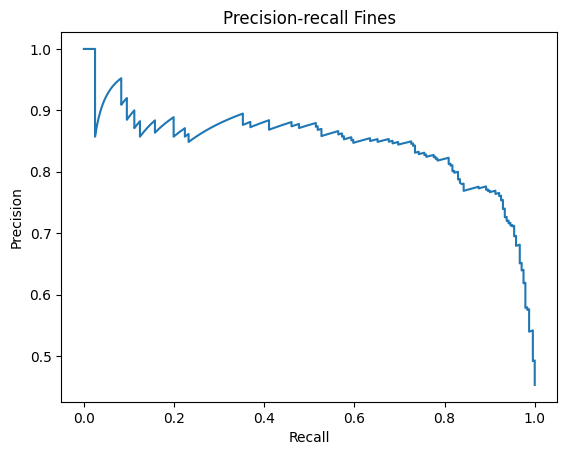

In [64]:
plt.plot(recall_fines_auc, precision_fines_auc)
plt.title("Precision-recall Fines")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

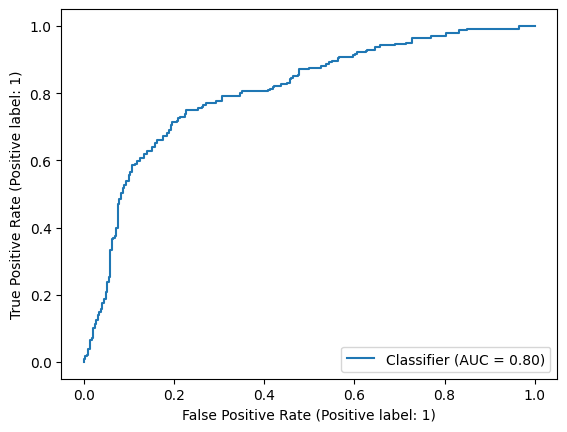

In [56]:
RocCurveDisplay.from_predictions(tokenized_fines['class'], fines_probs)
plt.show()

## 4.4 Volatility modeling

In [ ]:
def get_realized_vol(dataset, time):
    '''
    Compute realized volatility proxy for given time interval
    '''
    dataset.fillna(0, inplace = True)
    realized_volatility = dataset.groupby('date')['log_returns'].sum()
    return realized_volatility

os.chdir('HF_data/15min')
hf_data = pd.DataFrame()

for file in os.listdir():
    hf_data = pd.concat([hf_data,pd.read_csv(file,sep=';')])

#get returns and log_returns

hf_data['returns'] = 100*hf_data["<CLOSE>"].pct_change()
hf_data['log_returns'] = np.log(hf_data["<CLOSE>"]/hf_data["<CLOSE>"].shift(1))

os.chdir('..')
hf_data.to_csv('HF_data_15min.csv')

#compute daily realized volatility based on 15-min interval returns
rv  = get_realized_vol(hf_data, 36)
print(rv.tail())
rv.to_csv('realized_vol.csv')

In [ ]:
# fit GARCH model without news indexes
model = arch.arch_model(moex_data['return'],mean='AR',p=1,o=1,dist='normal',lags=0)
res = model.fit()
print(res.summary)

#volatility forecasting

In [ ]:
MAPE_base = mean_absolute_percentage_error(rv,vol_forecast)
RMSE_base = mean_squared_error(rv,vol_forecast, squared = False)

In [ ]:
# fit model GARCH with exogenous variable(p=1,o=1 setup)
news_model = arch.arch_model(y = moex_data['return'],x=mean_ind['labels'],
                             mean='ARX', p=1,o=1, dist="normal",lags=0)
res = news_model.fit()
print(res.summary)
print(res.conditional_volatility)

In [ ]:
MAPE = mean_absolute_percentage_error(rv,vol_forecast_x)
RMSE = mean_squared_error(rv,vol_forecast_x, squared = False)

In [ ]:
print("Out-of-sample metrics")
print("Without news information")
print("MAPE:",MAPE_base)
print("RMSE:",RMSE_base)
print("With news information")
print("MAPE:",MAPE)
print("RMSE:",RMSE)

In [ ]:
moex_data[['<DATE>','<CLOSE>','return','log_ret']].to_csv('returns.csv')